# Neural Networks -Hands-on Session

---


---


During this session, we will solve the super famous handwritten digit recognition task by training a neural network on the MNIST dataset.


## Data





### Data Loading

In this session, we will be dealing with digit recognition data (MNIST). It is a famous dataset frequently used in machine leanring. Keras has a functionality that loads the data (split into train and test)

In [5]:
from keras.datasets import mnist
(X_train_val, y_train_val), (X_test, y_test) = mnist.load_data()


### Data Scaling

To map all pixel values to [0,1] range we can normalize the data by dividing by 255 which is the max pixel value. 

In [6]:
X_train_val = X_train_val / 255
X_test = X_test / 255


### Data Visualization

To better understand the data, we will plot 64 random images from the training dataset

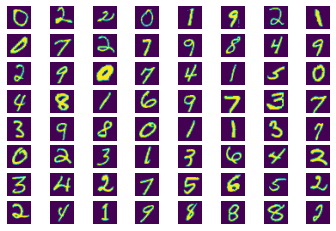

In [7]:
import matplotlib.pyplot as plt
from random import randint

for i in range(64):
    ax = plt.subplot(8, 8, i+1)
    ax.axis('off')
    plt.imshow(X_train_val[randint(0, X_train_val.shape[0])]) #, cmap='Greys')

### Data Reshaping 
Let's see the shape of the data

In [8]:
print("Training/Validation data shape: ", X_train_val.shape) # (60000, 28, 28) -- 60000 images, each 28x28 pixels
print("Test data shape", X_test.shape) # (10000, 28, 28) -- 10000 images, each 28x28


Training/Validation data shape:  (60000, 28, 28)
Test data shape (10000, 28, 28)


Since we don't know how to deal with 2-dimensional inputs, we will flatten our input. In other words, we will transform the (28, 28) image into a vector of size 28x28.

It is worth mentioning that convolutional neural networks (CNNs) are specifically designed for image processing/computer vision to maintain these spatial relationships. 

In [9]:
# Flatten the images
image_vector_size = 28*28
X_train_val = X_train_val.reshape(X_train_val.shape[0], image_vector_size)
X_test = X_test.reshape(X_test.shape[0], image_vector_size)

### Data Splitting

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.25, shuffle=True)

In [11]:
print("X: training:", X_train.shape, "- Validation:", X_val.shape, "- Testing:", X_test.shape)

X: training: (45000, 784) - Validation: (15000, 784) - Testing: (10000, 784)


### One-hot Encoding

We have to do one last thing to this dataset before we’re ready to experiment with some neural networks. The labels for this dataset are numerical values from 0 to 9 — but it’s important that our algorithm treats these as items in a set, rather than ordinal values. In our dataset the value “0” isn’t smaller than the value “9”, they are just two different values from our set of possible classifications.

If our algorithm predicts “8” when it should predict “0” it is wrong to say that the model was “off by 8” — it simply predicted the wrong category. Similarly, predicting “7” when we should have predicted “8” is not better than predicting “0” when we should have predicted “8” — both are just wrong.

To address this issue, when we’re making predictions about categorical data (as opposed to values from a continuous range), the best practice is to use a “one-hot encoded” vector. This means that we create a vector as long as the number of categories we have, and force the model to set exactly one of the positions in the vector to 1 and the rest to 0 (the single 1 is the “hot” value within the vector).

Thankfully, Keras makes this remarkably easy to do as well:


In [12]:
from keras.utils import to_categorical

# Convert to "one-hot" vectors using the to_categorical function
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)
print("First 5 training lables as one-hot encoded vectors:\n", y_train[:5])

First 5 training lables as one-hot encoded vectors:
 [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


Finally, it is worth mentioning that there are a lot of other things we could do at this point to normalize/improve the input images themselves. Preprocessing is common (because it’s a good idea) but we’re going to ignore it for now. Our focus is on examining neural network architectures.

## Building The model

The neural network in this article has the same input as a vector with 784 entries — this is the data from the flattened 28x28 image. 

The output layer was also implicitly defined earlier when we created a one-hot encoded vector from the labels — the ten labels correspond to the ten nodes in this layer.


Our output layer also uses a special activation function called softmax. This normalizes the values from the ten output nodes such that:

* all the values are between 0 and 1, and
* the sum of all ten values is 1.


This allows us to treat those ten output values as probabilities, and the largest one is selected as the prediction for the one-hot vector. 

In machine learning, the softmax function is almost always used when our model’s output is a one-hot encoded vector.


Finally, this model has a single hidden layer with 32 nodes using the sigmoid activation function. 

In [13]:
from keras.models import Sequential
from keras.layers import Dense

image_size = 28*28
h_units = [784, 500, 500, 500, 500, 500]
out_units = 10

In [14]:

model = Sequential() # neural network

# The input layer requires the special input_shape parameter which should match
# the shape of our training data.
model.add(Dense(units=h_units[0], activation='relu', input_shape=(image_size,)))

for u in range(1, len(h_units)):
  model.add(Dense(units=h_units[u], activation='relu'))

model.add(Dense(out_units, activation='softmax'))


Let's print our model

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 784)               615440    
_________________________________________________________________
dense_1 (Dense)              (None, 500)               392500    
_________________________________________________________________
dense_2 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_3 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_4 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_5 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_6 (Dense)              (None, 10)                5

To train this model, we will use the *stochastic gradient descent* algorithm with a *categorical crossentropy loss* function while monitoring the accuracy. 

The `'categorical_crossentropy'` loss Computes the crossentropy loss between the labels and predictions when there are two or more label classes in a one_hot representation. 

In [16]:
model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])


## Training The Model

Like before, the `fit()` function will train the model. 

Epoch 1/5
352/352 - 13s - loss: 1.8294 - accuracy: 0.5384 - val_loss: 0.8206 - val_accuracy: 0.8044
Epoch 2/5
352/352 - 13s - loss: 0.5187 - accuracy: 0.8574 - val_loss: 0.3865 - val_accuracy: 0.8876
Epoch 3/5
352/352 - 13s - loss: 0.3424 - accuracy: 0.9026 - val_loss: 0.3165 - val_accuracy: 0.9072
Epoch 4/5
352/352 - 13s - loss: 0.2824 - accuracy: 0.9180 - val_loss: 0.2733 - val_accuracy: 0.9179
Epoch 5/5
352/352 - 13s - loss: 0.2452 - accuracy: 0.9290 - val_loss: 0.2515 - val_accuracy: 0.9269


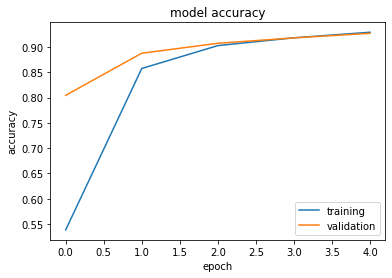

Validation loss: 0.251
Validation accuracy: 0.927


In [17]:
history = model.fit(X_train, y_train, batch_size=128, epochs=5, verbose=2, validation_data=(X_val, y_val)) # talk about validation_split
loss, accuracy  = model.evaluate(X_val, y_val, verbose=False)


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

print(f'Validation loss: {loss:.3}')
print(f'Validation accuracy: {accuracy:.3}')

Performance varies a little bit from run to run (give it a try in the Jupyter notebook), but accuracy is consistently between 87–95%. This is an incredible result!!




## Testing the Model
Let's choose a random testing instance


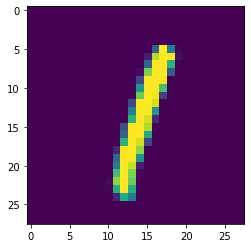

In [19]:
idx = 5
plt.imshow(X_test[idx].reshape(28,28))

In [21]:
import numpy as np
print("Actual label (one hot encoding)", y_test[idx])
print("Actual label", np.argmax(y_test[idx]))

Actual label (one hot encoding) [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Actual label 1


In [22]:
preds = model.predict(X_test)

print("Predicted label (probabilities)", preds[idx])
print("Predicted label", np.argmax(preds[idx]))

Predicted label (probabilities) [7.3199999e-07 9.8352033e-01 9.7192609e-04 1.0134500e-03 1.3751282e-04
 9.5612297e-05 7.8836492e-05 1.2046585e-02 1.5824747e-03 5.5267219e-04]
Predicted label 1


## Regularization


Regularization helps when your model suffers from overfitting
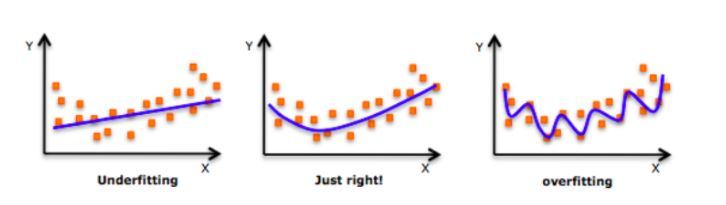

In (deep) neural networks, regularization can be achived by: 


*   L1 and L2 regularization on the cost function level
*   Dropout on the layer/neuron-level
*   Early stopping on the training level
*   .....



### L2 regularization

L1 and L2 are the most common types of regularization. These update the general cost function by adding another term known as the regularization term.

Cost function = Loss (say, binary cross entropy) + Regularization term

Due to the addition of this regularization term, the values of weight matrices decrease because it assumes that a neural network with smaller weight matrices leads to simpler models. Therefore, it will also reduce overfitting to quite an extent.

However, this regularization term differs in L1 and L2.

In L2, we have:


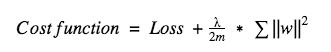

Here, lambda is the regularization parameter. It is the hyperparameter whose value is optimized for better results. L2 regularization is also known as weight decay as it forces the weights to decay towards zero (but not exactly zero).

In L1, we have:

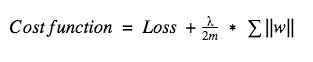



Now, let’s try the L2 regularizer over it and check whether it gives better results than a simple neural network model.

In [23]:
from keras import regularizers

lmbda = 0.0001

model = Sequential() # neural network

# The input layer requires the special input_shape parameter which should match
# the shape of our training data.
model.add(Dense(units=h_units[0], activation='relu', input_shape=(image_size,)))

for u in range(1, len(h_units)):
  model.add(Dense(units=h_units[u], activation='relu', 
                  kernel_regularizer=regularizers.l2(lmbda) # you can change to .l1
                  )
  )

model.add(Dense(out_units, activation='softmax'))

model.summary()
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 784)               615440    
_________________________________________________________________
dense_8 (Dense)              (None, 500)               392500    
_________________________________________________________________
dense_9 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_10 (Dense)             (None, 500)               250500    
_________________________________________________________________
dense_11 (Dense)             (None, 500)               250500    
_________________________________________________________________
dense_12 (Dense)             (None, 500)               250500    
_________________________________________________________________
dense_13 (Dense)             (None, 10)               

Train the new model

Epoch 1/5
352/352 - 15s - loss: 2.1351 - accuracy: 0.5264 - val_loss: 1.0977 - val_accuracy: 0.8017
Epoch 2/5
352/352 - 14s - loss: 0.7924 - accuracy: 0.8526 - val_loss: 0.6504 - val_accuracy: 0.8871
Epoch 3/5
352/352 - 14s - loss: 0.6052 - accuracy: 0.9006 - val_loss: 0.5977 - val_accuracy: 0.8983
Epoch 4/5
352/352 - 14s - loss: 0.5441 - accuracy: 0.9189 - val_loss: 0.5397 - val_accuracy: 0.9149
Epoch 5/5
352/352 - 14s - loss: 0.5058 - accuracy: 0.9300 - val_loss: 0.4953 - val_accuracy: 0.9310


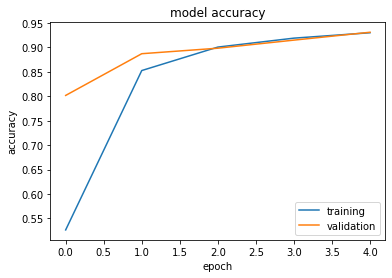

Validation loss: 0.495
Validation accuracy: 0.931


In [24]:
history = model.fit(X_train, y_train, batch_size=128, epochs=5, verbose=2, validation_data=(X_val, y_val)) # talk about validation_split
loss, accuracy  = model.evaluate(X_val, y_val, verbose=False)


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

print(f'Validation loss: {loss:.3}')
print(f'Validation accuracy: {accuracy:.3}')

### Dropout

This is the one of the most interesting types of regularization techniques. It also produces very good results and is consequently the most frequently used regularization technique in the field of deep learning.

Consider the following neural network

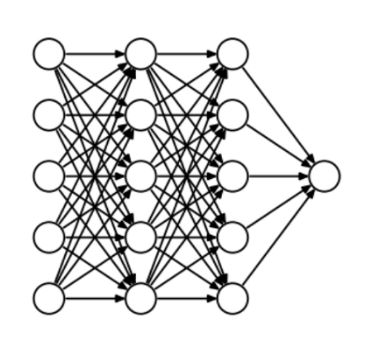

Dropout methods randomly selects some nodes, at every iteration, and removes them along with all of their incoming and outgoing connections as shown below if their weight is negligible as shown below: 

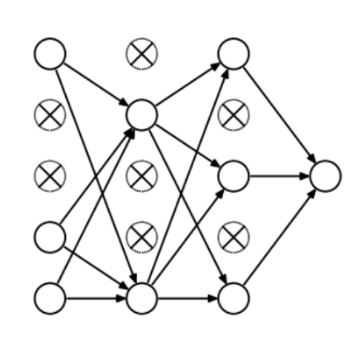

So each iteration has a different set of nodes and this results in a different set of outputs. It can also be thought of as an ensemble technique in machine learning.

Ensemble models usually perform better than a single model as they capture more randomness. Similarly, dropout also performs better than a normal neural network model.

We just need to choose the probability of choosing how many nodes should be dropped at every iteration. 

In [25]:
from keras.layers.core import Dropout

dropout_rate = 0.25

model = Sequential() # neural network

# The input layer requires the special input_shape parameter which should match
# the shape of our training data.
model.add(Dense(units=h_units[0], activation='relu', input_shape=(image_size,)))

for u in range(1, len(h_units)):
  model.add(Dense(units=h_units[u], activation='relu', 
                  kernel_regularizer=regularizers.l2(lmbda) # you can change to .l1
                  )
  )
  model.add(Dropout(dropout_rate))

model.add(Dense(out_units, activation='softmax'))

model.summary()
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 784)               615440    
_________________________________________________________________
dense_15 (Dense)             (None, 500)               392500    
_________________________________________________________________
dropout (Dropout)            (None, 500)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_2 (Dropout)          (None, 500)              

Epoch 1/5
352/352 - 16s - loss: 2.4858 - accuracy: 0.1753 - val_loss: 2.2242 - val_accuracy: 0.5710
Epoch 2/5
352/352 - 15s - loss: 1.7613 - accuracy: 0.5244 - val_loss: 0.9807 - val_accuracy: 0.7712
Epoch 3/5
352/352 - 15s - loss: 1.0100 - accuracy: 0.7552 - val_loss: 0.7078 - val_accuracy: 0.8605
Epoch 4/5
352/352 - 15s - loss: 0.7947 - accuracy: 0.8351 - val_loss: 0.6103 - val_accuracy: 0.8940
Epoch 5/5
352/352 - 15s - loss: 0.6920 - accuracy: 0.8707 - val_loss: 0.5612 - val_accuracy: 0.9089


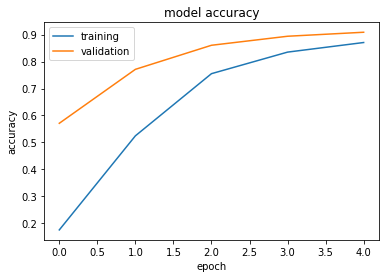

Validation loss: 0.561
Validation accuracy: 0.909


In [26]:
history = model.fit(X_train, y_train, batch_size=128, epochs=5, verbose=2, validation_data=(X_val, y_val)) # talk about validation_split
loss, accuracy  = model.evaluate(X_val, y_val, verbose=False)


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

print(f'Validation loss: {loss:.3}')
print(f'Validation accuracy: {accuracy:.3}')

### Early Stopping

Early stopping monitors the validation set. When we see that the performance on the validation set is getting worse, we immediately stop the training on the model.

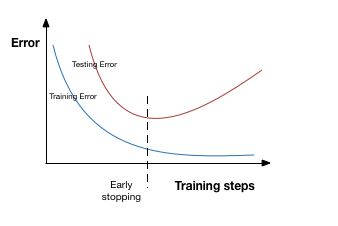

We need to specify the quantity to monitor (```val_error```). 

We also need to specify the patience which denotes the number of epochs with no further improvement after which the training will be stopped. 

In [28]:
from keras.callbacks import EarlyStopping

model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
es = EarlyStopping(monitor='val_acc', patience=2)
trained_model_5d = model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val), callbacks = [es])

Epoch 1/5
1407/1407 [==============================] - 31s 22ms/step - loss: 0.4968 - accuracy: 0.9307 - val_loss: 0.4199 - val_accuracy: 0.9513
Epoch 2/5
1407/1407 [==============================] - 31s 22ms/step - loss: 0.4426 - accuracy: 0.9454 - val_loss: 0.4097 - val_accuracy: 0.9555
Epoch 3/5
1407/1407 [==============================] - 31s 22ms/step - loss: 0.4103 - accuracy: 0.9546 - val_loss: 0.3947 - val_accuracy: 0.9591
Epoch 4/5
1407/1407 [==============================] - 31s 22ms/step - loss: 0.3851 - accuracy: 0.9629 - val_loss: 0.3718 - val_accuracy: 0.9661
Epoch 5/5
1407/1407 [==============================] - 30s 21ms/step - loss: 0.3649 - accuracy: 0.9677 - val_loss: 0.3607 - val_accuracy: 0.9695


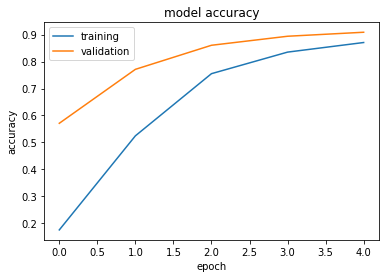

Validation loss: 0.361
Validation accuracy: 0.97


In [29]:
loss, accuracy  = model.evaluate(X_val, y_val, verbose=False)


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

print(f'Validation loss: {loss:.3}')
print(f'Validation accuracy: {accuracy:.3}')

## Model Saving 

You can save an entire model to a single artifact. It will include:

* The model's architecture/config
* The model's weight values (which were learned during training)
* The model's compilation information (if compile()) was called
* The optimizer and its state, if any 

(this enables you to restart training where you left)

In [ ]:
model.save('best_model')

INFO:tensorflow:Assets written to: best_model/assets


To load it again (in later runs)

In [ ]:
from tensorflow import keras

reconstructed_model  = keras.models.load_model('best_model')
print(reconstructed_model .summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 784)               615440    
_________________________________________________________________
dense_42 (Dense)             (None, 500)               392500    
_________________________________________________________________
dropout (Dropout)            (None, 500)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_44 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_2 (Dropout)          (None, 500)              

### Saving Checkpoints
Checkpointing is setup to save the network weights only when there is an improvement in classification accuracy on the validation dataset (monitor=’val_accuracy’ and mode=’max’). The weights are stored in a file that includes the score in the filename (weights-improvement-{val_accuracy=.2f}.hdf5)


In [ ]:
from keras.callbacks import ModelCheckpoint

# checkpoint
filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

trained_model_5d = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks = [checkpoint]) # [checkpoint, es]

Epoch 1/10
1406/1407 [============================>.] - ETA: 0s - loss: 0.2977 - accuracy: 0.9855
Epoch 00001: val_accuracy improved from -inf to 0.97727, saving model to weights-improvement-01-0.98.hdf5
1407/1407 [==============================] - 34s 24ms/step - loss: 0.2977 - accuracy: 0.9855 - val_loss: 0.3289 - val_accuracy: 0.9773
Epoch 2/10
1405/1407 [============================>.] - ETA: 0s - loss: 0.2926 - accuracy: 0.9865
Epoch 00002: val_accuracy did not improve from 0.97727
1407/1407 [==============================] - 34s 24ms/step - loss: 0.2926 - accuracy: 0.9865 - val_loss: 0.3274 - val_accuracy: 0.9772
Epoch 3/10
1405/1407 [============================>.] - ETA: 0s - loss: 0.2857 - accuracy: 0.9886
Epoch 00003: val_accuracy did not improve from 0.97727
1407/1407 [==============================] - 34s 24ms/step - loss: 0.2857 - accuracy: 0.9886 - val_loss: 0.3246 - val_accuracy: 0.9765
Epoch 4/10
1407/1407 [==============================] - ETA: 0s - loss: 0.2809 - accu

To load a saved checkpoint you need to have the model (architecture) already created. Only weights will be loaded. 

You need to have someting like: 



```
model = Sequential() # neural network

# The input layer requires the special input_shape parameter which should match
# the shape of our training data.
model.add(Dense(units=h_units[0], activation='relu', input_shape=(image_size,)))

for u in range(1, len(h_units)):
  model.add(Dense(units=h_units[u], activation='relu', 
                  kernel_regularizer=regularizers.l2(lmbda) # you can change to .l1
                  )
  )
  model.add(Dropout(dropout_rate))

model.add(Dense(out_units, activation='softmax'))

```
then you load the weights!



In [ ]:
# model.load_weights("weights.best.hdf5")

## Is deep learning that easy to code?
We have obfuscated spatial relationships within the data by flattening the images. We have done zero feature extraction to help the model understand the data. Yet, in under one minute of training, we’re already doing nearly nine times better than guessing randomly.

If we want to exploit the 2d relationship in the data we have to use more advanced layers. 

Convolutional layers are usually used to deal with image data. The theory of convolution is not covered in this tutorial. The goal is just to show you how to implement a deep learning model, Convolutional Neural Network (CNN) specifically in keras. 

Let's reshape the data

In [42]:
X_train = X_train.reshape(X_train.shape[0], 28,28,1)
X_val = X_val.reshape(X_val.shape[0], 28,28,1)
X_test = X_test.reshape(X_test.shape[0], 28,28,1)

In [43]:
X_train.shape

(45000, 28, 28, 1)

Defining a model is very similar to the traditional neural network but ```Dense``` layers are replaced by ```Convolutional```  and ```Pooling``` layers.

In [45]:
from keras.layers import Conv2D, MaxPooling2D, Flatten

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu',  input_shape=(28, 28,1)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(10, activation='softmax'))
# compile model
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])


Epoch 1/5
352/352 - 16s - loss: 0.5128 - accuracy: 0.8663 - val_loss: 0.3133 - val_accuracy: 0.9118
Epoch 2/5
352/352 - 16s - loss: 0.2758 - accuracy: 0.9226 - val_loss: 0.2521 - val_accuracy: 0.9273
Epoch 3/5
352/352 - 16s - loss: 0.2316 - accuracy: 0.9342 - val_loss: 0.2234 - val_accuracy: 0.9328
Epoch 4/5
352/352 - 16s - loss: 0.2033 - accuracy: 0.9425 - val_loss: 0.1987 - val_accuracy: 0.9425
Epoch 5/5
352/352 - 16s - loss: 0.1824 - accuracy: 0.9481 - val_loss: 0.1841 - val_accuracy: 0.9453


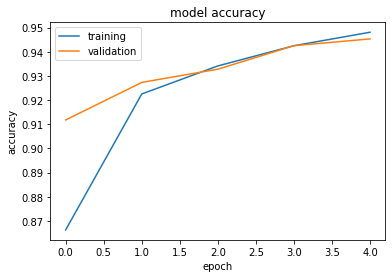

Validation loss: 0.184
Validation accuracy: 0.945


In [46]:
history = model.fit(X_train, y_train, batch_size=128, epochs=5, verbose=2, validation_data=(X_val, y_val)) # talk about validation_split
loss, accuracy  = model.evaluate(X_val, y_val, verbose=False)


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

print(f'Validation loss: {loss:.3}')
print(f'Validation accuracy: {accuracy:.3}')